In [8]:
from datasets import load_from_disk
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
import cv2
import os
from transformers import CLIPModel, CLIPProcessor, Trainer, TrainingArguments
from sklearn.metrics import roc_auc_score, f1_score, multilabel_confusion_matrix, roc_curve, auc, accuracy_score
import random
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from utils import compute_all_metrics_with_ci

In [9]:
train_dataset = load_from_disk("nlmcxr_labeled_train")
test_dataset = load_from_disk("nlmcxr_labeled_test")

In [10]:
class NLMCXRCLIPDataset(Dataset):
    def __init__(self, dataset, processor, transform=None):
        self.dataset = dataset
        self.processor = processor
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        text = sample['text']

        image = sample['image']  # should be a PIL.Image
        if not isinstance(image, Image.Image):
            image = Image.open(image).convert("RGB")
        
        label_vector = torch.tensor(sample['label_vector'], dtype=torch.float32)

        # Apply CLIP processor
        inputs = self.processor(
            text=text,
            images=image,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=77
        )

        return {
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "pixel_values": inputs["pixel_values"].squeeze(0),
            "label_vector": label_vector
        }

# Create a processor
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Create dataset objects
train_dataset_pytorch = NLMCXRCLIPDataset(train_dataset, processor)
test_dataset_pytorch = NLMCXRCLIPDataset(test_dataset, processor)

# Example: Load a sample
sample = train_dataset_pytorch[0]
print("Text:", sample['input_ids'].shape)
print("Image shape:", sample['pixel_values'].shape)
print("Label vector:", sample['label_vector'].shape)

Text: torch.Size([77])
Image shape: torch.Size([3, 224, 224])
Label vector: torch.Size([14])


In [11]:
# Create subset datasets
train_subset = Subset(train_dataset_pytorch, random.sample(range(len(train_dataset)), 240))  # Adjust the range as needed
val_subset = Subset(train_dataset_pytorch, random.sample(range(len(train_dataset)), 30))
test_subset = Subset(test_dataset_pytorch, random.sample(range(len(test_dataset)), 30))  # Adjust the range as needed

In [12]:
class CLIPMultimodalClassifier(nn.Module):
    def __init__(self, model_name="openai/clip-vit-base-patch32", num_labels=14):
        super(CLIPMultimodalClassifier, self).__init__()
        self.clip = CLIPModel.from_pretrained(model_name)

        for param in self.clip.parameters():
            param.requires_grad = False

        embed_dim = self.clip.config.projection_dim
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim * 2, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_labels)
        )

    def forward(self, input_ids, attention_mask, pixel_values, label_vector, output_attentions=False):
        outputs = self.clip(input_ids=input_ids, attention_mask=attention_mask, pixel_values=pixel_values, output_attentions=output_attentions, return_dict=True)
        text_emb = outputs.text_embeds
        image_emb = outputs.image_embeds
        fused = torch.cat((text_emb, image_emb), dim=1)
        logits = self.classifier(fused)

        result = {"logits": logits}

        if label_vector is not None:
            loss_fn = nn.BCEWithLogitsLoss()
            loss = loss_fn(logits, label_vector)
            result["loss"] = loss

        if output_attentions:
            result["text_attentions"] = outputs.text_model_output.attentions
            result["image_attentions"] = outputs.vision_model_output.attentions

        return result
    
    def state_dict(self, *args, **kwargs):
        state_dict = super().state_dict(*args, **kwargs)
        # Make the visual_projection.weight tensor contiguous
        if "clip.visual_projection.weight" in state_dict:
            state_dict["clip.visual_projection.weight"] = state_dict["clip.visual_projection.weight"].contiguous()
        return state_dict

In [13]:
model = CLIPMultimodalClassifier(num_labels=14)

training_args = TrainingArguments(
    output_dir="./results_clip",
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    learning_rate=5e-2,
    warmup_steps=200,
    lr_scheduler_type='cosine',
    load_best_model_at_end=True,
    weight_decay=1e-4,
    logging_steps=10,
    save_strategy="epoch",
    logging_dir="./logs",
    metric_for_best_model="f1",
    remove_unused_columns=False,
    save_safetensors=False
)

def compute_metrics(pred):
    logits, labels = pred
    preds = torch.sigmoid(torch.tensor(logits)) > 0.5
    labels = torch.tensor(labels)
    # accuracy = (preds == labels).float().mean().item()
    accuracy = accuracy_score(labels, preds)
    return {
        "accuracy": accuracy,
        "f1": f1_score(labels, preds, average="micro"),
        "roc_auc": roc_auc_score(labels, preds, average="micro")
    }

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_subset,
    eval_dataset=val_subset,
)

In [14]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Roc Auc
1,0.346400,0.310751,0.000000,0.000000,0.500000
2,0.275200,0.252187,0.100000,0.142857,0.537930
3,0.233300,0.232482,0.200000,0.311111,0.593289
4,0.183100,0.254221,0.433333,0.461538,0.685731
5,0.178300,0.298502,0.233333,0.307692,0.598970
6,0.156700,0.288975,0.300000,0.392857,0.638205
7,0.179900,0.226113,0.333333,0.508475,0.693564
8,0.119600,0.221162,0.333333,0.553846,0.730188
9,0.075400,0.256291,0.433333,0.575758,0.743702
10,0.055500,0.243423,0.400000,0.557377,0.720591


c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: '

TrainOutput(global_step=300, training_loss=0.1901098213593165, metrics={'train_runtime': 374.5615, 'train_samples_per_second': 6.407, 'train_steps_per_second': 0.801, 'total_flos': 0.0, 'train_loss': 0.1901098213593165, 'epoch': 10.0})

In [15]:
torch.save(model.state_dict(), 'clip_chest_model.pth')

In [16]:
# Save the model
trainer.save_model()

trainer.evaluate()

c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.25629088282585144,
 'eval_accuracy': 0.43333333333333335,
 'eval_f1': 0.5757575757575758,
 'eval_roc_auc': 0.7437019264695506,
 'eval_runtime': 5.0098,
 'eval_samples_per_second': 5.988,
 'eval_steps_per_second': 0.798,
 'epoch': 10.0}

In [17]:
model.load_state_dict(torch.load("clip_chest_model.pth"))

<All keys matched successfully>

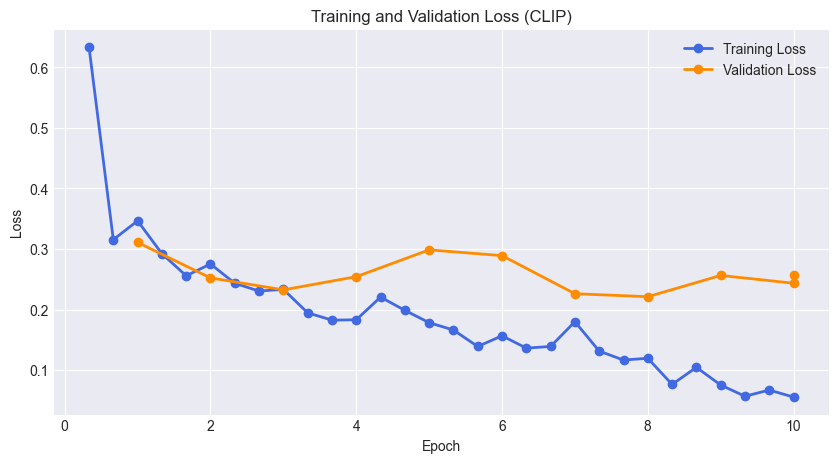

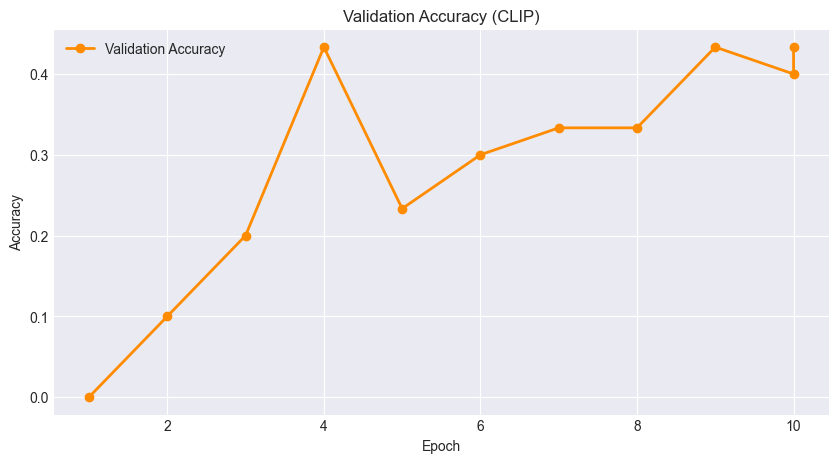

In [18]:
# Extract logs
logs = trainer.state.log_history

train_loss = []
eval_loss = []
eval_accuracy = []
train_epochs = []
eval_epochs = []

for log in logs:
    if "loss" in log and "epoch" in log and "eval_loss" not in log:
        train_loss.append(log["loss"])
        train_epochs.append(log["epoch"])
    if "eval_loss" in log:
        eval_loss.append(log["eval_loss"])
        eval_epochs.append(log["epoch"])  # store matching epoch
    if "eval_accuracy" in log:
        eval_accuracy.append(log["eval_accuracy"])

plt.style.use('seaborn-v0_8-darkgrid')
# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(train_epochs, train_loss, label="Training Loss", marker='o', linewidth=2, color='royalblue')
plt.plot(eval_epochs, eval_loss, label="Validation Loss", marker='o', linewidth=2, color='darkorange')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss (CLIP)")
plt.legend()
plt.grid(True)
plt.savefig("clip_chest_loss.png")
plt.show()

# Plot Accuracy (optional, if accuracy was computed)
if eval_accuracy:
    plt.figure(figsize=(10, 5))
    plt.plot(eval_epochs[:len(eval_accuracy)], eval_accuracy, label="Validation Accuracy", marker='o', linewidth=2, color='darkorange')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy (CLIP)")
    plt.legend()
    plt.grid(True)
    plt.savefig("clip_chest_accuracy.png")
    plt.show()

In [19]:
# Use the Trainer's predict method on the test dataset
predictions = trainer.predict(test_subset)

# Extract logits and labels
logits = predictions.predictions
all_labels = predictions.label_ids

# Convert logits to binary predictions
binary_preds = (torch.sigmoid(torch.tensor(logits)) > 0.5).int().numpy()

print("All Labels Shape:", all_labels.shape)
print("Binary Predictions Shape:", binary_preds.shape)

c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


All Labels Shape: (30, 14)
Binary Predictions Shape: (30, 14)


In [20]:
y_true = all_labels
y_pred = binary_preds
y_pred_probs = torch.sigmoid(torch.tensor(logits)).numpy()

results = compute_all_metrics_with_ci(y_true, y_pred, y_prob=y_pred_probs, multilabel=True)

for metric, (mean_val, (low, high)) in results.items():
    if mean_val is not None:
        print(f"{metric}: {mean_val:.3f} (90% CI: {low:.3f} - {high:.3f})")
    else:
        print(f"{metric}: Not available")

accuracy: 0.398 (90% CI: 0.267 - 0.567)
f1: 0.448 (90% CI: 0.298 - 0.597)
auroc: 0.909 (90% CI: 0.856 - 0.952)
mcc: 0.429 (90% CI: 0.281 - 0.581)
brier: 0.059 (90% CI: 0.042 - 0.075)
sensitivity: 0.147 (90% CI: 0.067 - 0.216)
specificity: 0.971 (90% CI: 0.956 - 0.986)
balanced_accuracy: 0.558 (90% CI: 0.518 - 0.595)


In [21]:
sample_idx = 10  # Change this to view a different sample
print(f"Confidence scores for test sample {sample_idx}:")
print("Per-class confidence scores:", y_pred_probs[sample_idx])
print("Predicted labels:", y_pred[sample_idx])
print("Ground truth labels:", y_true[sample_idx])

Confidence scores for test sample 10:
Per-class confidence scores: [3.3599159e-04 1.1546637e-04 8.7394419e-06 4.5613284e-05 3.8685454e-03
 8.7790545e-03 8.9326590e-05 1.0783484e-04 2.7575798e-04 8.9126179e-06
 2.8734978e-03 1.2004720e-02 2.1351613e-03 8.0425429e-01]
Predicted labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 1]
Ground truth labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


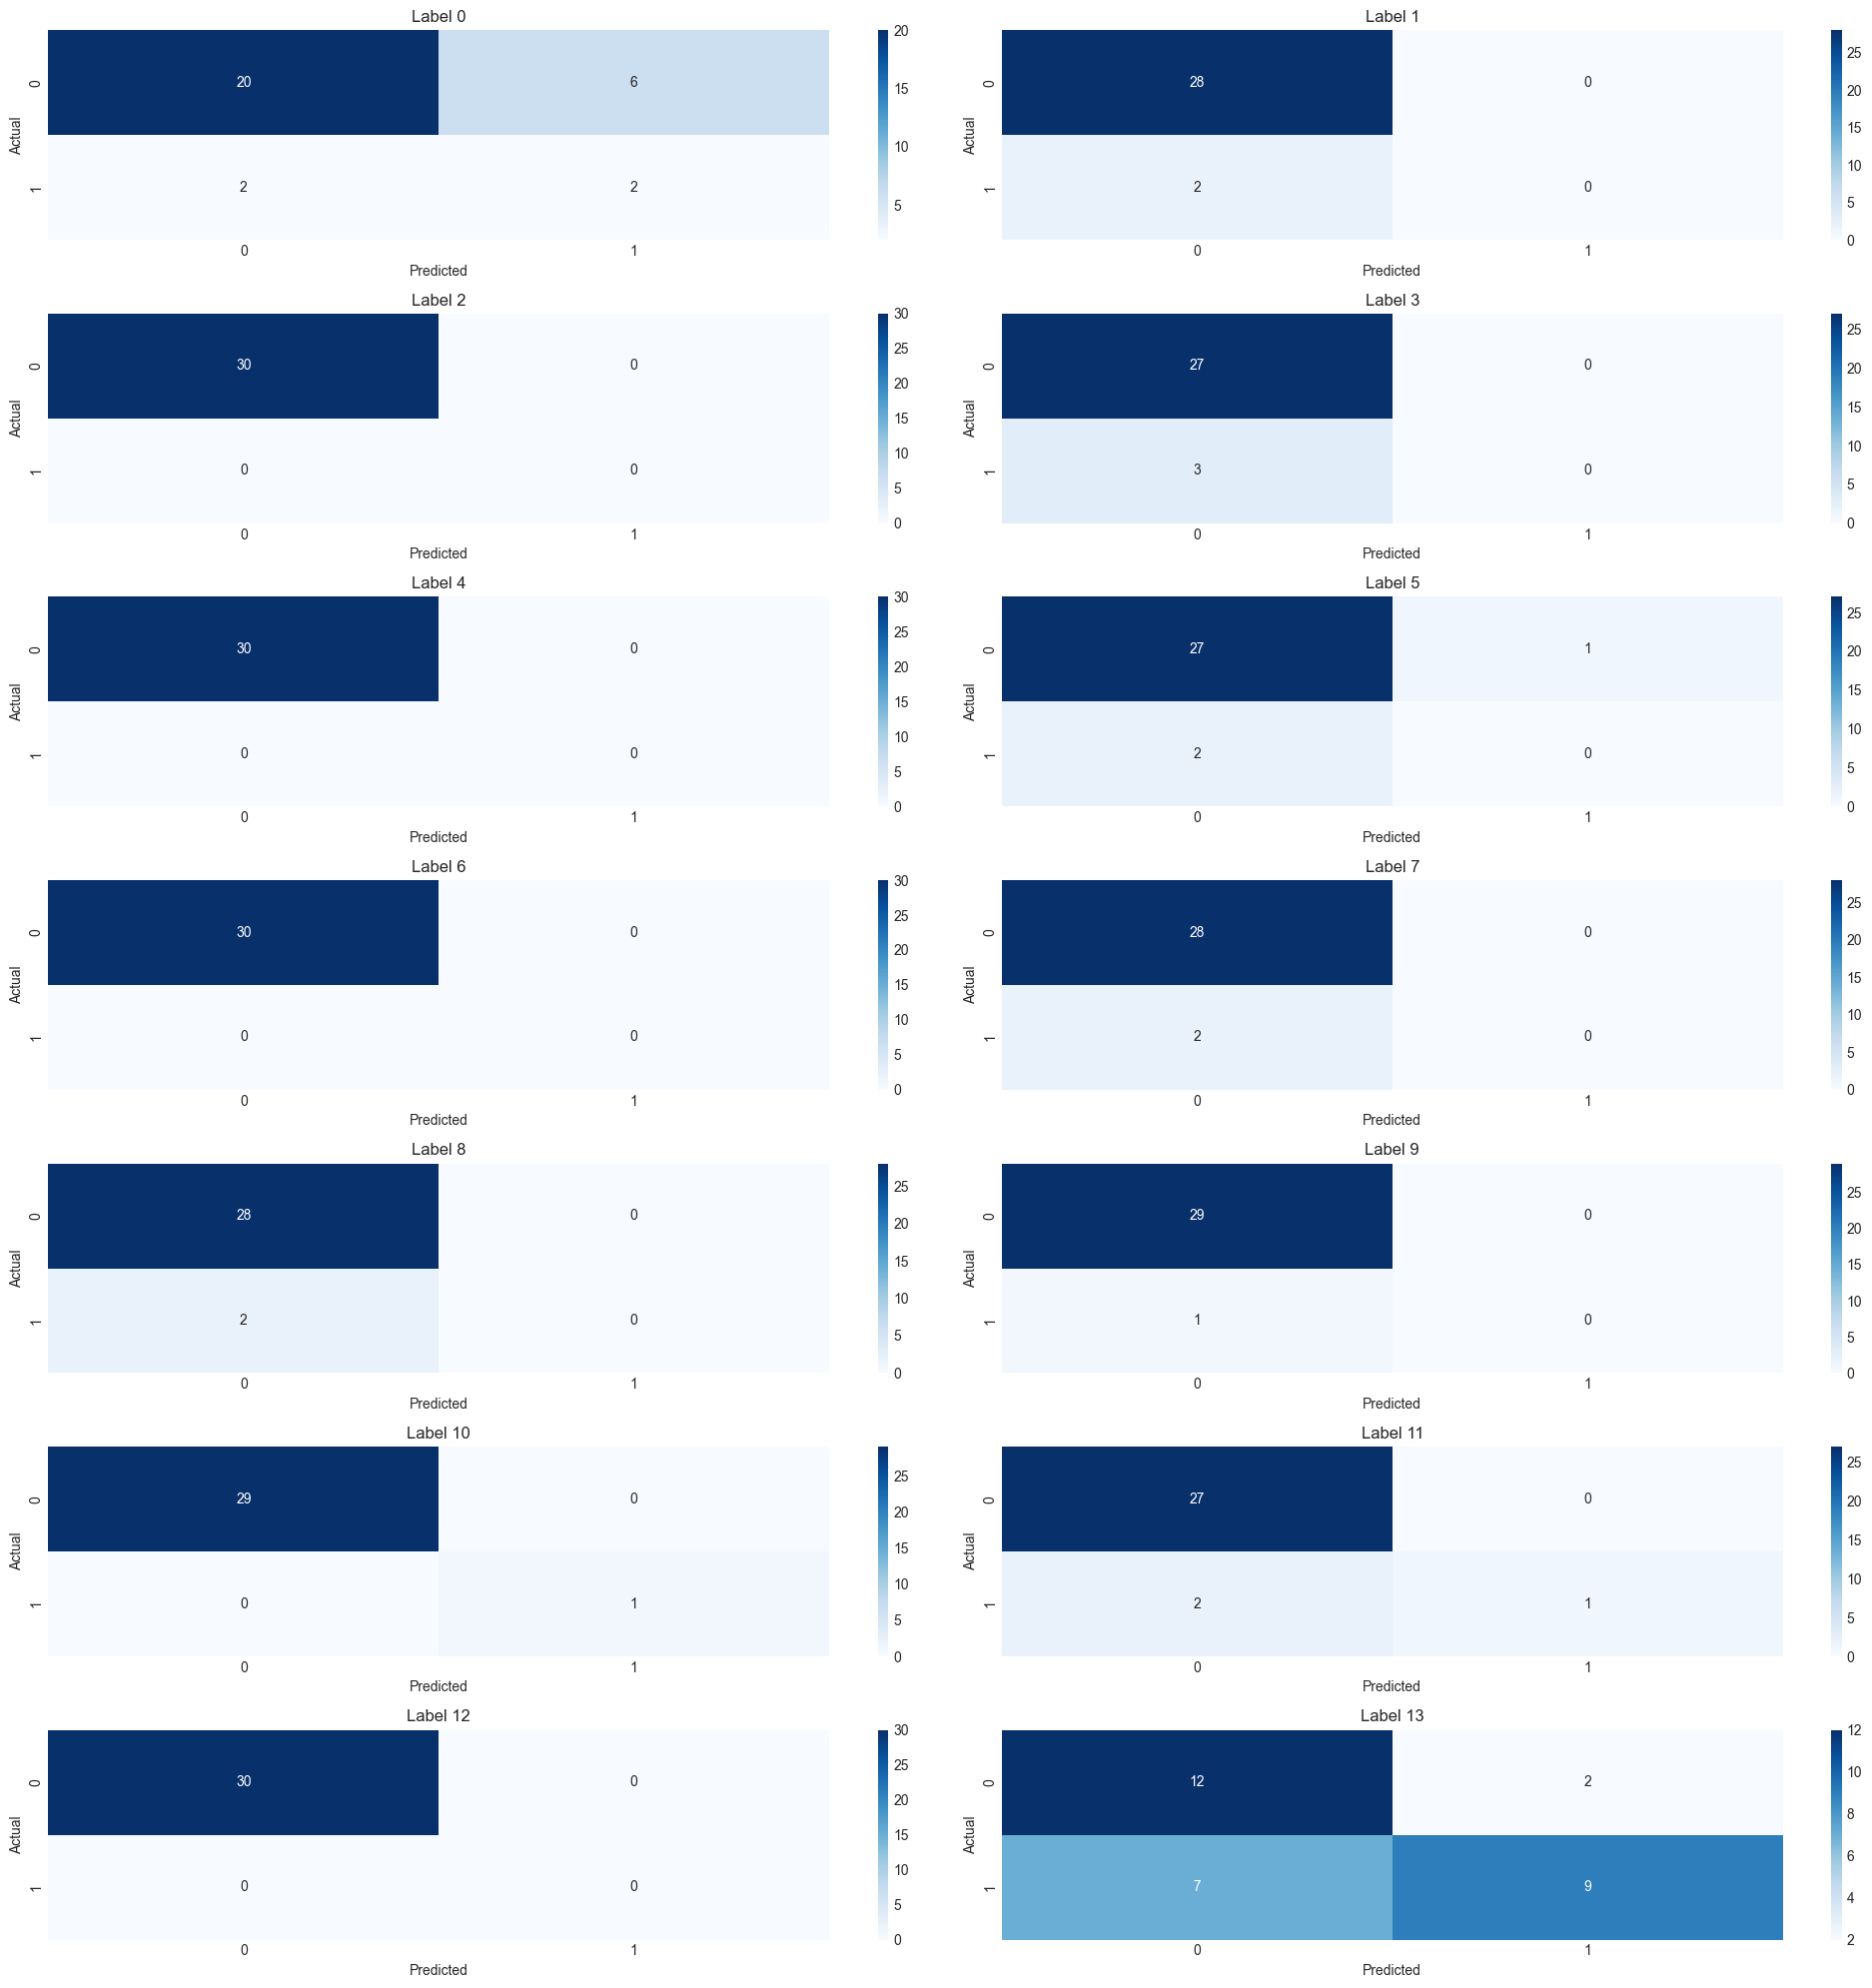

In [22]:
# Assuming `all_labels` and `binary_preds` are available from the evaluation function
# Compute the multilabel confusion matrix
confusion_matrices = multilabel_confusion_matrix(all_labels, binary_preds)

# Plot each confusion matrix
num_labels = confusion_matrices.shape[0]
fig, axes = plt.subplots(7, 2, figsize=(20, 20))

axes = axes.flatten()

for i, ax in enumerate(axes):
    cm = confusion_matrices[i]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Label {i}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [23]:
class_names = [
    "Atelectasis",
    "Consolidation",
    "Infiltration",
    "Pneumothorax",
    "Edema",
    "Emphysema",
    "Fibrosis",
    "Effusion",
    "Pneumonia",
    "Pleural_thickening",
    "Cardiomegaly",
    "Nodule Mass",
    "Hernia",
    "No Finding"
]

print("Class Names:", class_names)

Class Names: ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_thickening', 'Cardiomegaly', 'Nodule Mass', 'Hernia', 'No Finding']


In [24]:
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    matthews_corrcoef,
    brier_score_loss
)

def compute_additional_metrics(labels, preds):
    
    metrics = {
        "micro_f1": f1_score(labels, preds, average="micro"),
        "macro_f1": f1_score(labels, preds, average="macro"),
        "roc_auc_micro": roc_auc_score(labels, preds, average="micro"),
        "matthews_corrcoef_micro": matthews_corrcoef(labels.flatten(), preds.flatten()),
    }

    # Compute brier score for each class
    brier_scores = []
    for i in range(labels.shape[1]):
        brier_scores.append(brier_score_loss(labels[:, i], preds[:, i]))
    
    metrics["brier_score_avg"] = sum(brier_scores) / len(brier_scores)

    sensitivities = []
    specificities = []
    balanced_accuracies = []

    for cm in confusion_matrices:
        TN, FP, FN, TP = cm.ravel()

        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        balanced_accuracy = (sensitivity + specificity) / 2

        sensitivities.append(sensitivity)
        specificities.append(specificity)
        balanced_accuracies.append(balanced_accuracy)

    metrics["sensitivity_avg"] = sum(sensitivities) / len(sensitivities)
    metrics["specificity_avg"] = sum(specificities) / len(specificities)
    metrics["balanced_accuracy_avg"] = sum(balanced_accuracies) / len(balanced_accuracies)

    return metrics


In [25]:
metrics = compute_additional_metrics(all_labels, binary_preds)

c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [26]:
# Print the metrics
print("Micro F1 Score:", metrics["micro_f1"])
print("ROC AUC Score (Micro):", metrics["roc_auc_micro"])
print("Matthews Correlation Coefficient (Micro):", metrics["matthews_corrcoef_micro"])
print("Brier Score (Average):", metrics["brier_score_avg"])
print("Sensitivity (Average):", metrics["sensitivity_avg"])
print("Specificity (Average):", metrics["specificity_avg"])
print("Balanced Accuracy (Average):", metrics["balanced_accuracy_avg"])


Micro F1 Score: 0.4482758620689655
ROC AUC Score (Micro): 0.6688368055555556
Matthews Correlation Coefficient (Micro): 0.42428835114640145
Brier Score (Average): 0.07619047619047618
Sensitivity (Average): 0.17113095238095236
Specificity (Average): 0.9707613814756673
Balanced Accuracy (Average): 0.5709461669283098
